# Cloud Classification with CNN
Dataset: CCSN 

Model: CloudNet architecture 

### Data Preparation

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [82]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, dataset_path, transform=None, copy=False):
        self.dataset_path = dataset_path
        self.transform = transform
        self.images = []
        self.labels = []
        self.copy = copy  
        self.class_to_label = {
            "Ac": 0,
            "Sc": 1,
            "Ns": 2,
            "Cu": 3,
            "Ci": 4,
            "Cc": 5,
            "Cb": 6,
            "As": 7,
            "Ct": 8,
            "Cs": 9,
            "St": 10
        }
        
        for class_name, label in self.class_to_label.items():
            class_path = os.path.join(self.dataset_path, class_name)
            for filename in os.listdir(class_path):
                if filename.endswith(".jpg"):
                    image_path = os.path.join(class_path, filename)
                    img = Image.open(image_path)
                    img = img.resize((227, 227))  # Adjust the size for input 
                    img = np.array(img)
                    self.images.append(img)
                    self.labels.append(label)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = Image.fromarray(image)  # Convert the NumPy array to a PIL Image
            image = self.transform(image)  # Apply the provided transform
        
        if self.copy:
            # Create a copy of the image if 'copy' is True
            image = np.copy(image)
        
        
        return image, label

In [159]:
def train_model(train_dataloader,val_dataloader, model, num_epochs, model_save_path):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_loss = total_loss / len(train_dataloader)
        training_accuracy = 100 * correct_train / total_train

        # Validation loop
        model.eval()
        with torch.no_grad():
            total = 0
            correct = 0
            for inputs, labels in val_dataloader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total

        print(f'Epoch {epoch + 1}, Loss: {average_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%')
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f'Saved the best model with validation accuracy: {accuracy:.2f}%')

# 1.1 Without preprocessing

In [31]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Resize to match the input size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

train_dataset = CustomImageDataset(dataset_path="./Cropped_split/train/", transform=transform)
val_dataset = CustomImageDataset(dataset_path="./Cropped_split/validation", transform=transform)
test_dataset = CustomImageDataset(dataset_path="./Cropped_split/test", transform=transform)

# Create dataloaders for each split
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

import torch
import torch.nn as nn

class CloudNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Layer 1: Convolution with 11x11 kernel, followed by Max-Pooling with 3x3 kernel
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2)
    
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        # Layer 2: Convolution with 5x5 kernel, followed by Max-Pooling with 3x3 kernel
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        # Layer 3: Convolution with 3x3 kernel
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)

        # Layer 4: Convolution with 3x3 kernel
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        # Layer 5: Fully Connected Layers with Dropout
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.dropout1 = nn.Dropout(0.5)

        # Layer 6: Fully Connected Layers with Dropout
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout2 = nn.Dropout(0.5)

        # Layer 7: Fully Connected Output Layer
        self.fc3 = nn.Linear(4096, 11)

    def forward(self, x):
        x = self.maxpool1(nn.functional.relu(self.conv1(x)))
        x = self.maxpool2(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = self.maxpool3(x)
        x = x.view(-1, 256 * 6 * 6)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout1(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


num_classes = 11  
model = CloudNet()
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 10  # Adjust the number of training epochs as needed

for epoch in range(num_epochs):
    # Training loop
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    average_loss = total_loss / len(train_dataloader)
    training_accuracy = 100 * correct_train / total_train
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1}, Loss: {average_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%')



CloudNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=4096, out_features=11, bias=True)
)
Epoch 1, Loss: 2.3945, Training Accuracy: 9.99%, Validation Accuracy: 12.40%
Epoch 2, Loss: 2.3861, Training Accuracy: 12.12%, Va

In [39]:
for epoch in range(10,30):
    # Training loop
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    average_loss = total_loss / len(train_dataloader)
    training_accuracy = 100 * correct_train / total_train
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1}, Loss: {average_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%')




Epoch 11, Loss: 2.2877, Training Accuracy: 17.55%, Validation Accuracy: 22.83%
Epoch 12, Loss: 2.2475, Training Accuracy: 16.44%, Validation Accuracy: 25.00%
Epoch 13, Loss: 2.2266, Training Accuracy: 18.10%, Validation Accuracy: 23.82%
Epoch 14, Loss: 2.2010, Training Accuracy: 19.75%, Validation Accuracy: 22.44%
Epoch 15, Loss: 2.1770, Training Accuracy: 19.91%, Validation Accuracy: 25.20%
Epoch 16, Loss: 2.1573, Training Accuracy: 21.16%, Validation Accuracy: 26.18%
Epoch 17, Loss: 2.1298, Training Accuracy: 23.13%, Validation Accuracy: 25.39%
Epoch 18, Loss: 2.1409, Training Accuracy: 22.03%, Validation Accuracy: 27.17%
Epoch 19, Loss: 2.1065, Training Accuracy: 24.39%, Validation Accuracy: 29.92%
Epoch 20, Loss: 2.1065, Training Accuracy: 23.29%, Validation Accuracy: 26.57%
Epoch 21, Loss: 2.0886, Training Accuracy: 24.78%, Validation Accuracy: 28.94%
Epoch 22, Loss: 2.0590, Training Accuracy: 26.67%, Validation Accuracy: 30.71%
Epoch 23, Loss: 2.0437, Training Accuracy: 26.75%, V

In [40]:
for epoch in range(30,100):
    # Training loop
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    average_loss = total_loss / len(train_dataloader)
    training_accuracy = 100 * correct_train / total_train
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1}, Loss: {average_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%')

Epoch 31, Loss: 1.9033, Training Accuracy: 32.65%, Validation Accuracy: 30.71%
Epoch 32, Loss: 1.8838, Training Accuracy: 34.78%, Validation Accuracy: 29.13%
Epoch 33, Loss: 1.8755, Training Accuracy: 35.09%, Validation Accuracy: 31.89%
Epoch 34, Loss: 1.8790, Training Accuracy: 32.97%, Validation Accuracy: 30.31%
Epoch 35, Loss: 1.8269, Training Accuracy: 35.88%, Validation Accuracy: 31.89%
Epoch 36, Loss: 1.8494, Training Accuracy: 35.72%, Validation Accuracy: 30.12%
Epoch 37, Loss: 1.7831, Training Accuracy: 37.06%, Validation Accuracy: 27.95%
Epoch 38, Loss: 1.7992, Training Accuracy: 36.98%, Validation Accuracy: 29.13%
Epoch 39, Loss: 1.7538, Training Accuracy: 37.61%, Validation Accuracy: 30.91%
Epoch 40, Loss: 1.7318, Training Accuracy: 38.87%, Validation Accuracy: 30.12%
Epoch 41, Loss: 1.6832, Training Accuracy: 40.60%, Validation Accuracy: 29.92%
Epoch 42, Loss: 1.6488, Training Accuracy: 41.62%, Validation Accuracy: 32.09%
Epoch 43, Loss: 1.6191, Training Accuracy: 43.12%, V

In [43]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to evaluate the model on a dataset
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs, labels
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Evaluate the model on the test dataset
test_accuracy = evaluate_model(model, test_dataloader)

print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 28.93%


In [115]:
# Save the model's state dictionary (parameters)
model_path = "model_wo_preprocessing.pth"
torch.save(model.state_dict(), model_path)

# 1.2 With mean value substraction 

In [60]:
# Create a new transformed dataset from the existing train_dataset
class TransformedDataset(Dataset):
    def __init__(self, original_dataset, transform):
        self.original_dataset = original_dataset
        self.transform = transform

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, label = self.original_dataset[idx]
        image = self.transform(image)
        return image, label

In [73]:
mean_values = [121.9284313391225/256, 133.10818522836797/256, 142.83502724299115/256]  
print("Mean values for RGB:", mean_values)

normalize = transforms.Compose([
#     transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
#     transforms.RandomResizedCrop(size=(227, 227), scale=(0.8, 1.0)),  # Randomly crop and resize
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust brightness, contrast, saturation, and hue
#     transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=mean_values, std=[1, 1, 1])  # Subtract mean values
])

# Create the new transformed dataset
normalized_dataset_train = TransformedDataset(train_dataset, normalize)
normalized_dataset_val = TransformedDataset(val_dataset, normalize)
normalized_dataset_test = TransformedDataset(test_dataset, normalize)

Mean values for RGB: [0.47628293491844725, 0.5199538485483124, 0.5579493251679342]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


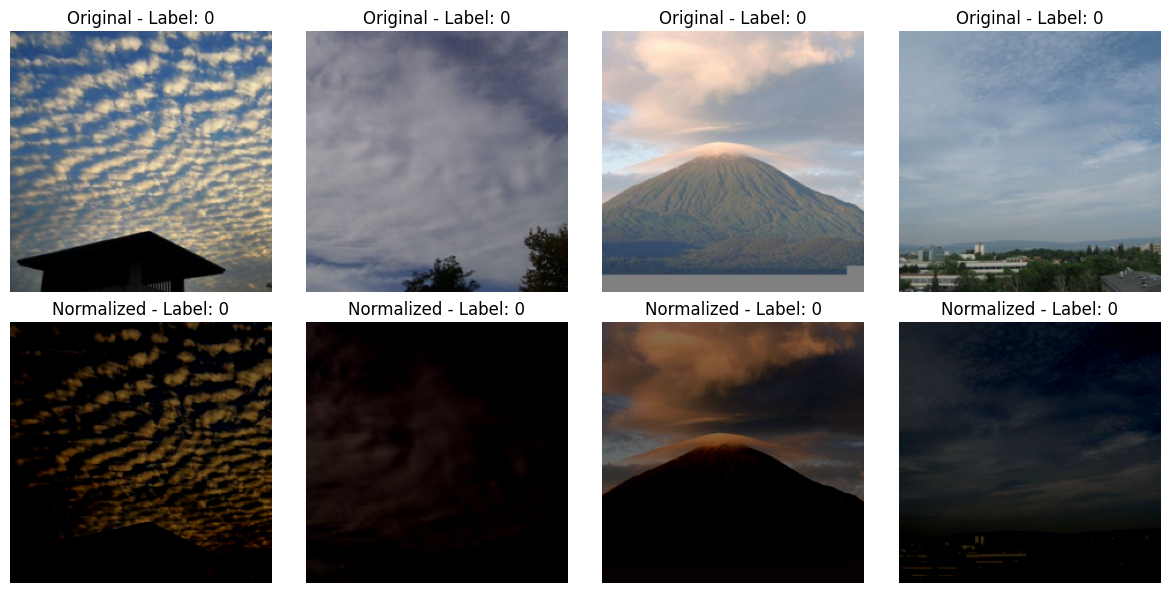

In [71]:
# Visualize 
import matplotlib.pyplot as plt
import numpy as np

# Create a dataloader for the transformed dataset
dataloader_0 = DataLoader(train_dataset, batch_size=4, shuffle=False)
normalize_dataloader_0 = DataLoader(normalized_dataset, batch_size=4, shuffle=False)

# Get the first batch from the data loader
batch_0 = next(iter(dataloader_0))
batch_norm = next(iter(normalize_dataloader_0))
images_0, labels_0 = batch_0
images_1, labels_1 = batch_norm

# Display the first 4 images from the original batch
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images_0[i].permute(1, 2, 0))  # Transpose to (height, width, channels)
    plt.title(f"Original - Label: {labels_0[i]}")
    plt.axis('off')

# Display the first 4 images from the normalized batch
for i in range(4):
    plt.subplot(2, 4, i + 5)
    plt.imshow(images_1[i].permute(1, 2, 0))  # Transpose to (height, width, channels)
    plt.title(f"Normalized - Label: {labels_1[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [74]:
num_classes = 11  
model_norm = CloudNet()
print(model_norm)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_norm.parameters(), lr=0.001, momentum=0.9)
num_epochs = 100  

batch_size = 8
norm_dataloader_train = DataLoader(normalized_dataset_train, batch_size=batch_size, shuffle=True)
norm_dataloader_val = DataLoader(normalized_dataset_val, batch_size=batch_size, shuffle=True)
norm_dataloader_test = DataLoader(normalized_dataset_test, batch_size=batch_size, shuffle=True)

CloudNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=4096, out_features=11, bias=True)
)


In [118]:
for epoch in range(18, num_epochs):
    # Training loop
    model_norm.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, labels in norm_dataloader_train:
        optimizer.zero_grad()
        outputs = model_norm(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    average_loss = total_loss / len(norm_dataloader_train)
    training_accuracy = 100 * correct_train / total_train
    
    # Validation loop
    model_norm.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for inputs, labels in norm_dataloader_val:
            outputs = model_norm(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1}, Loss: {average_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%')





Epoch 19, Loss: 2.0630, Training Accuracy: 26.04%, Validation Accuracy: 29.13%
Epoch 20, Loss: 2.0456, Training Accuracy: 26.28%, Validation Accuracy: 26.18%
Epoch 21, Loss: 2.0303, Training Accuracy: 27.62%, Validation Accuracy: 24.80%
Epoch 22, Loss: 2.0184, Training Accuracy: 27.07%, Validation Accuracy: 29.92%
Epoch 23, Loss: 2.0091, Training Accuracy: 29.03%, Validation Accuracy: 30.71%
Epoch 24, Loss: 1.9877, Training Accuracy: 30.61%, Validation Accuracy: 32.87%
Epoch 25, Loss: 1.9665, Training Accuracy: 31.00%, Validation Accuracy: 30.31%
Epoch 26, Loss: 1.9518, Training Accuracy: 30.84%, Validation Accuracy: 30.12%
Epoch 27, Loss: 1.9306, Training Accuracy: 29.82%, Validation Accuracy: 32.28%
Epoch 28, Loss: 1.9295, Training Accuracy: 30.06%, Validation Accuracy: 33.66%
Epoch 29, Loss: 1.9138, Training Accuracy: 30.76%, Validation Accuracy: 33.07%
Epoch 30, Loss: 1.8899, Training Accuracy: 32.02%, Validation Accuracy: 30.91%
Epoch 31, Loss: 1.8653, Training Accuracy: 34.07%, V

In [119]:
# Save the model's state dictionary (parameters)
model_norm_path = "model_norm.pth"
torch.save(model_norm.state_dict(), model_norm_path)

In [125]:
# Evaluate the model on the test dataset
test_accuracy = evaluate_model(model_norm, norm_dataloader_test)

print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 35.21%


# 1.3 With data augmentation

In [104]:
from torchvision import transforms


transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Resize to match the input size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])
original_train_dataset = CustomImageDataset(dataset_path="./Datasets/split/train/", transform=transform)

# Define a transformation for data augmentation
augmentation_transform_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.ToTensor()
    
])

augmentation_transform_2 = transforms.Compose([
    transforms.RandomResizedCrop(size=(227, 227), scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.ToTensor()
])

# Create a copy of the original training dataset
augmented_train_dataset_1 = CustomImageDataset(dataset_path="./Datasets/split/train/", transform=augmentation_transform_1)
augmented_train_dataset_2 = CustomImageDataset(dataset_path="./Datasets/split/train/", transform=augmentation_transform_2)

# Combine the original and augmented datasets
combined_train_dataset = torch.utils.data.ConcatDataset([original_train_dataset, augmented_train_dataset_1, augmented_train_dataset_2])

# Create a DataLoader for the combined dataset
batch_size = 8
combined_train_dataloader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)


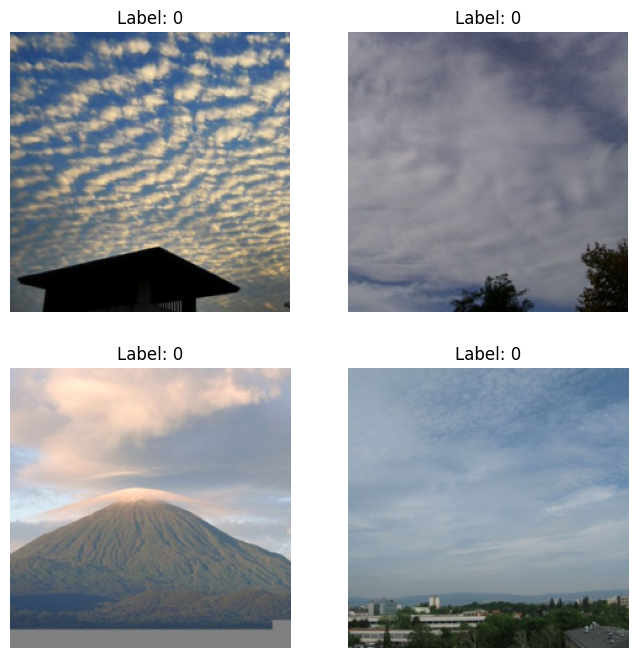

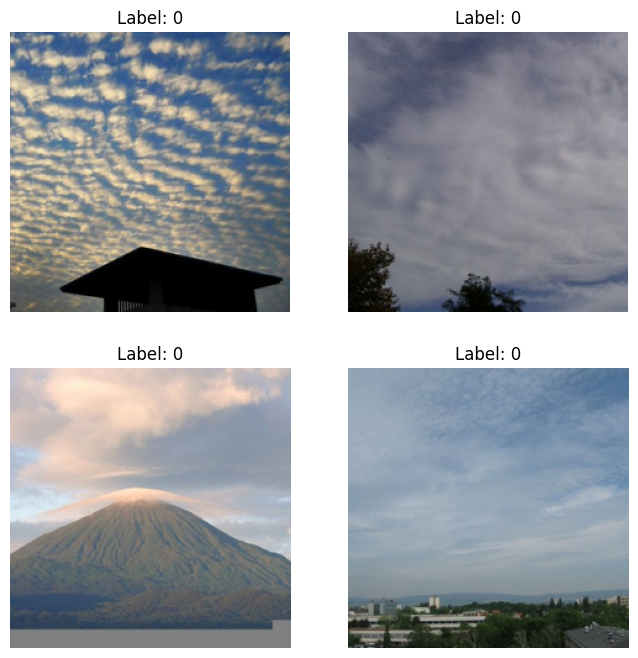

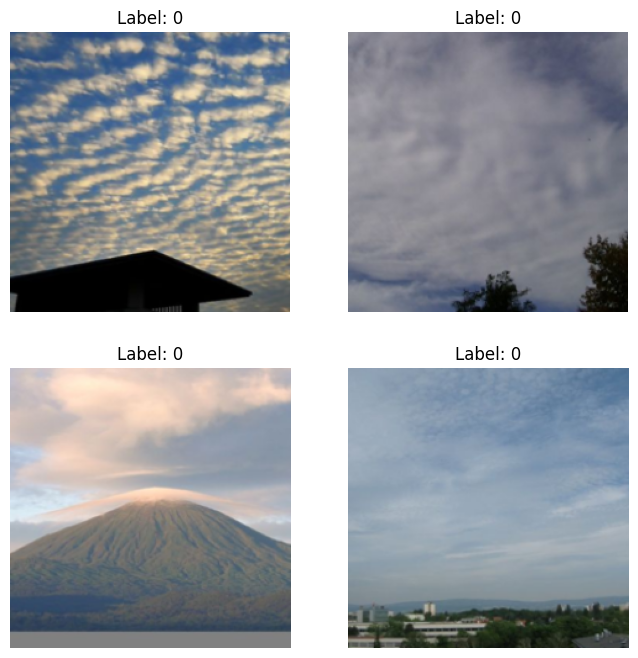

In [106]:
def display_images(dataset, num_images=4):
    # Create a subplot with 2 rows and 2 columns to display the first 4 images
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    
    for i in range(num_images):
        # Get the image and label from the dataset
        image, label = dataset[i]
        
        # Transpose the image to HWC format
        image = image.permute(1, 2, 0)
        
        ax = axes[i // 2, i % 2]
        ax.imshow(image)
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    
    plt.show()

# Display the first 4 images from the train dataset
display_images(original_train_dataset)
display_images(augmented_train_dataset_1)
display_images(augmented_train_dataset_2)


In [109]:
len(combined_train_dataset)

3813

In [111]:
num_classes = 11  
model_aug = CloudNet()
print(model_norm)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_norm.parameters(), lr=0.001, momentum=0.9)
num_epochs = 100  

batch_size = 8

CloudNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=4096, out_features=11, bias=True)
)


In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
    # Training loop
    model_aug.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, labels in combined_train_dataloader:
        optimizer.zero_grad()
        outputs = model_aug(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    average_loss = total_loss / len(combined_train_dataloader)
    training_accuracy = 100 * correct_train / total_train
    
    # Validation loop
    model_aug.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for inputs, labels in val_dataloader:
            outputs = model_aug(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1}, Loss: {average_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%')



In [ ]:
# Save the model's state dictionary (parameters)
model_aug_path = "model_aug.pth"
torch.save(model_aug.state_dict(), model_aug_path)

In [126]:
# Evaluate the model on the test dataset
test_accuracy = evaluate_model(model_aug, test_dataloader)

print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 7.46%


## 1.4 80% train

In [142]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Resize to match the input size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])
train_dataset_2 = CustomImageDataset(dataset_path="./Datasets/split_80/train", transform=transform)
val_dataset_2 = CustomImageDataset(dataset_path="./Datasets/split_80/validation/", transform=transform)
test_dataset_2 = CustomImageDataset(dataset_path="./Datasets/split_80/test", transform=transform)

# Create dataloaders for each split
batch_size = 8
train_dataloader_2 = DataLoader(train_dataset_2, batch_size=batch_size, shuffle=True)
val_dataloader_2 = DataLoader(val_dataset_2, batch_size=batch_size, shuffle=True)
test_dataloader_2 = DataLoader(test_dataset_2, batch_size=batch_size, shuffle=True)
num_classes = 11  
model_80 = CloudNet()
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 50  # Adjust the number of training epochs as needed



CloudNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=4096, out_features=11, bias=True)
)


In [ ]:
model_aug = CloudNet()
train_model(train_dataloader_2,val_dataloader_2, model_aug, 50)

In [127]:
# Evaluate the model on the test dataset
test_accuracy = evaluate_model(model_80, test_dataloader_2)

print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 8.63%


# 1.5 Crop lands

In [157]:
from PIL import Image
import torchvision.transforms as transforms

class CropUpperTwoThirds(object):
    def __call__(self, img):
        width, height = img.size
        new_height = int(height * 2 / 3)  # Calculate the new height (2/3 of the original height)
        return img.crop((0, 0, width, new_height))

transform = transforms.Compose([
    CropUpperTwoThirds(),  # Crop the upper 2/3 of the image
    transforms.Resize((227, 227)),  # Resize to match the input size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

train_dataset_crop = CustomImageDataset(dataset_path="./Datasets/split/train", transform=transform)
val_dataset_crop = CustomImageDataset(dataset_path="./Datasets/split/validation", transform=transform)
test_dataset_crop = CustomImageDataset(dataset_path="./Datasets/split/test", transform=transform)

# Create dataloaders for each split
batch_size = 8
train_dataloader_crop = DataLoader(train_dataset_crop, batch_size=batch_size, shuffle=True)
val_dataloader_crop = DataLoader(val_dataset_crop, batch_size=batch_size, shuffle=True)
test_dataloader_crop = DataLoader(test_dataset_crop, batch_size=batch_size, shuffle=True)


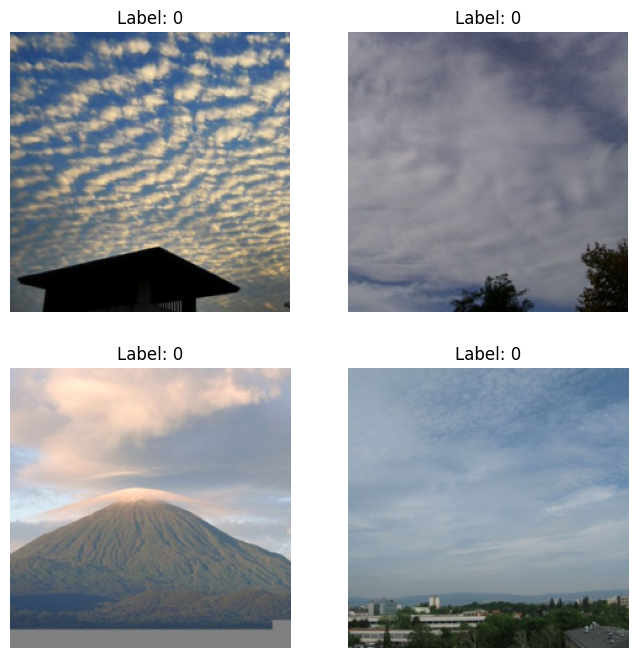

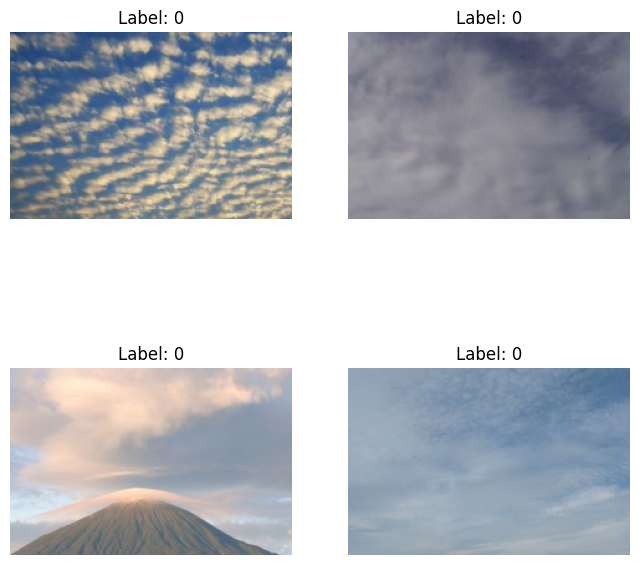

In [134]:
display_images(original_train_dataset)
display_images(train_dataset_crop)

In [158]:
model_crop = CloudNet()
num_epochs = 50
train_model(train_dataloader_crop,val_dataloader_crop, model_crop, 50)

Epoch 1, Loss: 2.3949, Training Accuracy: 9.91%, Validation Accuracy: 14.76%
Epoch 2, Loss: 2.3850, Training Accuracy: 11.96%, Validation Accuracy: 14.76%
Epoch 3, Loss: 2.3757, Training Accuracy: 11.80%, Validation Accuracy: 14.76%
Epoch 4, Loss: 2.3681, Training Accuracy: 12.20%, Validation Accuracy: 14.76%
Epoch 5, Loss: 2.3660, Training Accuracy: 12.35%, Validation Accuracy: 13.78%
Epoch 6, Loss: 2.3609, Training Accuracy: 11.25%, Validation Accuracy: 13.58%
Epoch 7, Loss: 2.3488, Training Accuracy: 12.27%, Validation Accuracy: 15.75%
Epoch 8, Loss: 2.3377, Training Accuracy: 14.87%, Validation Accuracy: 15.75%
Epoch 9, Loss: 2.3338, Training Accuracy: 14.56%, Validation Accuracy: 19.29%
Epoch 10, Loss: 2.3172, Training Accuracy: 15.89%, Validation Accuracy: 17.52%
Epoch 11, Loss: 2.3062, Training Accuracy: 15.34%, Validation Accuracy: 19.09%
Epoch 12, Loss: 2.2962, Training Accuracy: 16.29%, Validation Accuracy: 21.65%
Epoch 13, Loss: 2.2627, Training Accuracy: 17.07%, Validation 

KeyboardInterrupt: 

In [160]:
train_model(train_dataloader_crop,val_dataloader_crop, model_crop, 30, "model_crop.pth")

Epoch 1, Loss: 2.2083, Training Accuracy: 20.06%, Validation Accuracy: 22.83%
Saved the best model with validation accuracy: 22.83%
Epoch 2, Loss: 2.2022, Training Accuracy: 20.54%, Validation Accuracy: 24.21%
Saved the best model with validation accuracy: 24.21%
Epoch 3, Loss: 2.1974, Training Accuracy: 21.40%, Validation Accuracy: 21.46%
Epoch 4, Loss: 2.2019, Training Accuracy: 19.91%, Validation Accuracy: 21.26%
Epoch 5, Loss: 2.1756, Training Accuracy: 20.61%, Validation Accuracy: 22.05%
Epoch 6, Loss: 2.1625, Training Accuracy: 21.79%, Validation Accuracy: 22.05%
Epoch 7, Loss: 2.1730, Training Accuracy: 22.50%, Validation Accuracy: 22.64%
Epoch 8, Loss: 2.1570, Training Accuracy: 22.19%, Validation Accuracy: 28.35%
Saved the best model with validation accuracy: 28.35%
Epoch 9, Loss: 2.1537, Training Accuracy: 23.92%, Validation Accuracy: 24.21%
Epoch 10, Loss: 2.1440, Training Accuracy: 24.78%, Validation Accuracy: 26.57%
Epoch 11, Loss: 2.1311, Training Accuracy: 24.78%, Valida

In [164]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Resize to match the input size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

train_dataset = CustomImageDataset(dataset_path="./Datasets/split/train", transform=transform)
val_dataset = CustomImageDataset(dataset_path="./Datasets/split/validation", transform=transform)
test_dataset = CustomImageDataset(dataset_path="./Datasets/split/test", transform=transform)

# Create dataloaders for each split
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



In [165]:
class CloudNet2(nn.Module):
    def __init__(self):
        super().__init__()
        # Layer 1: Convolution with 11x11 kernel, followed by Max-Pooling with 3x3 kernel
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        # Layer 2: Convolution with 5x5 kernel, followed by Max-Pooling with 3x3 kernel
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        # Layer 3: Convolution with 3x3 kernel
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)

        # Layer 4: Convolution with 3x3 kernel
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        # Layer 5: Fully Connected Layers with Dropout
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.dropout1 = nn.Dropout(0.5)

        # Layer 6: Fully Connected Layers with Dropout
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout2 = nn.Dropout(0.5)

        # Layer 7: Fully Connected Output Layer
        self.fc3 = nn.Linear(4096, 11)

    def forward(self, x):
        x = self.maxpool1(nn.functional.relu(self.conv1(x)))
        x = self.maxpool2(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = self.maxpool3(x)
        x = x.view(-1, 256 * 6 * 6)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout1(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.dropout2(x)
        x = nn.functional.softmax(self.fc3(x), dim=1)
        return x


In [168]:
num_classes = 11  
model_2 = CloudNet2()
print(model_2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)
num_epochs = 50  # Adjust the number of training epochs as needed

for epoch in range(num_epochs):
    # Training loop
    model_2.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model_2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    average_loss = total_loss / len(train_dataloader)
    training_accuracy = 100 * correct_train / total_train
    
    # Validation loop
    model_2.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for inputs, labels in val_dataloader:
            outputs = model_2(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(correct, total)
    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1}, Loss: {average_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%')



CloudNet2(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=4096, out_features=11, bias=True)
)
71 508
Epoch 1, Loss: 2.3978, Training Accuracy: 9.60%, Validation Accuracy: 13.98%
65 508
Epoch 2, Loss: 2.3978, Training Accur

KeyboardInterrupt: 